<center>
<img src="../../img/ods_stickers.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) - Open Machine Learning Course

Author: [Yury Kashnitsky](https://www.linkedin.com/in/festline/). All content is distributed under the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license.

## <center> Assignment 4 (demo)
### <center>  Sarcasm detection with logistic regression
    
**Same assignment as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit) + [solution](https://www.kaggle.com/kashnitsky/a4-demo-sarcasm-detection-with-logit-solution).**


We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
!ls ../input/sarcasm/

test-balanced.csv    train-balanced-sarcasm.csv
test-unbalanced.csv  train-balanced-sarc.csv.gz


In [2]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
import itertools
import eli5

In [3]:
train_df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [7]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [8]:
train_texts, valid_texts, y_train, y_valid = \
        train_test_split(train_df['comment'], train_df['label'], random_state=17)

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

# 1. Dataset Analysis

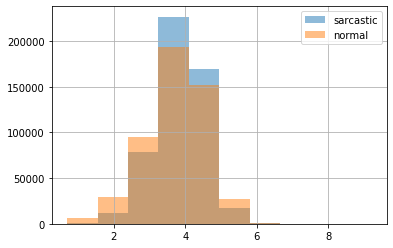

In [9]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

In [10]:
train_df.groupby('subreddit')['label'].agg([np.sum, np.mean, np.size]).sort_values(by='sum', ascending=False).head(10)

,sum,mean,size
subreddit,,,
AskReddit,26365,0.401453,65674
politics,23907,0.605348,39493
worldnews,16947,0.642516,26376
leagueoflegends,11407,0.542312,21034
pcmasterrace,10759,0.566651,18987
news,10193,0.603457,16891
funny,8099,0.451474,17939
pics,7823,0.484336,16152
todayilearned,7753,0.547567,14159


In [11]:
train_df.groupby('author')['label'].agg([np.sum, np.mean, np.size]).sort_values(by='sum', ascending=False).head(10)

,sum,mean,size
author,,,
Biffingston,422,0.499408,845
pokemon_fetish,216,0.500000,432
NeonDisease,211,0.500000,422
ShyBiDude89,202,0.500000,404
ivsciguy,171,0.500000,342
mad-n-fla,159,0.500000,318
mindlessrabble,151,0.500000,302
Canada_girl,150,0.500000,300
Chaoslab,126,0.500000,252


In [12]:
train_df[train_df['score'] >= 0].groupby('score')['label'].agg([np.sum, np.mean, np.size]).sort_values(by='sum', ascending=False).head(10)

,sum,mean,size
score,,,
1,148415,0.436519,339997
2,76755,0.471848,162669
3,44440,0.492208,90287
0,35626,0.612752,58141
4,22171,0.528158,41978
5,20399,0.525747,38800
6,15772,0.532856,29599
7,12143,0.533407,22765
8,9563,0.529395,18064


In [13]:
train_df[train_df['score'] < 0].groupby('score')['label'].agg([np.sum, np.mean, np.size]).sort_values(by='sum', ascending=False).head(10)

,sum,mean,size
score,,,
-1,14984,0.656934,22809
-2,8060,0.675948,11924
-3,4554,0.676069,6736
-4,3661,0.673473,5436
-5,2805,0.678520,4134
-6,2127,0.688795,3088
-7,1631,0.672855,2424
-8,1289,0.696004,1852
-9,1039,0.691284,1503


# 2. Build a Tf-Idf + logistic regression pipeline

In [14]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=50000, min_df=3)

In [15]:
lgr = LogisticRegression(solver='lbfgs', C=1, random_state=17, verbose=1, n_jobs=-1)

In [16]:
pipeline = Pipeline([('tfidf', tfidf), ('lgr', lgr)])

In [17]:
%%time
pipeline.fit(train_texts, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CPU times: user 52.5 s, sys: 1.78 s, total: 54.2 s
Wall time: 1min 7s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   14.1s finished


Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=3, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lgr',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=

In [18]:
preds = pipeline.predict(valid_texts)

In [19]:
accuracy_score(y_valid, preds)

0.7218097778340602

In [20]:
'''
https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
'''

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Confusion matrix, without normalization
[[95664 30644]
 [39653 86733]]


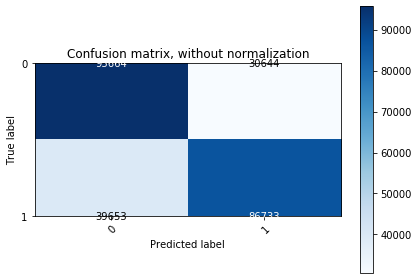

In [21]:
plot_confusion_matrix(y_valid, preds, pipeline.named_steps['lgr'].classes_)

# 3. Plot the words/bigrams which a most predictive of sarcasm

In [22]:
eli5.show_weights(estimator=pipeline.named_steps['lgr'],vec=pipeline.named_steps['tfidf'])

Weight?,Feature
+9.091,yes because
+7.401,obviously
+7.362,clearly
+7.331,yeah because
+6.770,totally
+6.163,because
+5.687,don you know
+5.414,how dare
+5.384,right because
+5.172,good thing


# 4. Add subreddits as new features to improve model performance

In [23]:
tfidf_text = TfidfVectorizer(ngram_range=(1, 3), max_features=50000, min_df=3)
tfidf_subreddit = TfidfVectorizer()

In [24]:
%%time
train_texts_tfidf = tfidf_text.fit_transform(train_texts)
valid_texts_tfidf = tfidf_text.transform(valid_texts)

CPU times: user 1min 1s, sys: 4.58 s, total: 1min 5s
Wall time: 1min 6s


In [25]:
train_texts_tfidf.shape, valid_texts_tfidf.shape

((758079, 50000), (252694, 50000))

In [26]:
train_subreddits, valid_subreddits = train_test_split(train_df['subreddit'], random_state=17)

In [27]:
%%time
train_texts_subreddits = tfidf_subreddit.fit_transform(train_subreddits)
valid_texts_subreddits = tfidf_subreddit.transform(valid_subreddits)

CPU times: user 2.78 s, sys: 0 ns, total: 2.78 s
Wall time: 2.79 s


In [28]:
train_texts_subreddits.shape, valid_texts_subreddits.shape

((758079, 13255), (252694, 13255))

In [29]:
from scipy.sparse import hstack
X_train = hstack([train_texts_tfidf, train_texts_subreddits])
X_valid = hstack([valid_texts_tfidf, valid_texts_subreddits])

In [30]:
lgr = LogisticRegression(random_state=17, n_jobs=-1, solver='lbfgs', verbose=1, C=1)

In [31]:
lgr.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   38.3s finished


LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=-1, penalty='l2', random_state=17,
                   solver='lbfgs', tol=0.0001, verbose=1, warm_start=False)

In [32]:
preds = lgr.predict(X_valid)

In [33]:
accuracy_score(y_valid, preds)

0.725937299658876